In [14]:
import dgl
from model.model import gasa_classifier
import torch
from model.data import predict_collate, pred_data
from torch.utils.data import DataLoader
import os
import numpy as np
from model.gasa_utils import generate_graph
from IPython.display import display, SVG
from rdkit import Chem
import matplotlib.cm as cm
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D

In [17]:
def explain(smiles):
    ls_smi = []
    if isinstance(smiles, list):  
        ls_smi = smiles
    else:
        ls_smi.append(smiles)
    graph = generate_graph(ls_smi)
    data = pred_data(graph=graph, smiles=ls_smi) 
    data_loader = DataLoader(data, batch_size=1, shuffle=False, collate_fn=predict_collate)
    dataset = data_loader.dataset
    model = gasa_classifier(dropout=0.1, num_heads=6, hidden_dim1=128, hidden_dim2=64, hidden_dim3=32)
    path = os.getcwd()
    pth = os.path.join(path, "model/gasa.pth")
    checkpoint = torch.load(pth, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['model_state_dict'])
    smiles, graph = dataset[0] 
    bg = dgl.batch([graph])
    atom_weight = model(bg)[1]
    atom_weights = atom_weight.cpu().detach().numpy()
    ls = []
    for i in list(range(0, len(atom_weights))):
        ls.append(atom_weights[i][0])
    min_value = min(ls)
    max_value = max(ls)
    weights = (ls - min_value) / (max_value - min_value)
    mol = Chem.MolFromSmiles(smiles)
    norm = cm.colors.Normalize(vmin=0, vmax=1.00)
    cmap = cm.get_cmap('OrRd') 
    plt_colors = cm.ScalarMappable(norm=norm, cmap=cmap)
    atom_colors = {i: plt_colors.to_rgba(weights[i]) for i in range(bg.number_of_nodes())}
    rdDepictor.Compute2DCoords(mol)
    dr = rdMolDraw2D.MolDraw2DSVG(400, 370)
    do = rdMolDraw2D.MolDrawOptions()
    do.bondLineWidth = 4
    do.fixedBondLength = 30
    do.highlightRadius = 4
    dr.SetFontSize(1)
    dr.drawOptions().addAtomIndices = True
    mol = rdMolDraw2D.PrepareMolForDrawing(mol)
    dr.DrawMolecule(mol, highlightAtoms=range(bg.number_of_nodes()),
                        highlightBonds=[],
                        highlightAtomColors=atom_colors)
    dr.FinishDrawing()
    svg = dr.GetDrawingText()
    svg = svg.replace('svg:', '')
    return svg

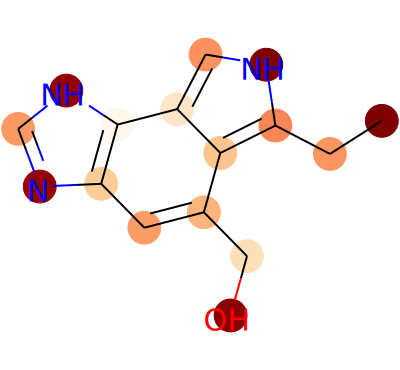

In [18]:
smiles = 'CCc1[nH]cc2c1c(CO)cc1nc[nH]c12'
svg = explain(smiles)
display(SVG(svg))